<hr style="border:2px solid #808080"> </hr>
<center><h1 style="color:#03122E;"> Álgebra Lineal Numérica IMT2111</h1></center>
<center><h1 style="color:#173F8A;"> Capítulo 2</h3></center>
<center><h1 style="color:#0176DE;"> Prof. Manuel A. Sánchez</h3></center>
<hr style="border:2px solid #808080"> </hr>

In [30]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

## Iteracion de Lanczos
$$ A = Q T Q^\top $$


In [31]:
def Lanczos1(A, q1, TOL=1e-14, MAXITER = 100):
    '''
    Input  : A simetrica, q1, \|q1\|=`
    Output : Qk = [q1|q2|...|qk] orthonormal, Tk[k,k] = alphak, Tk[k+1,k]=Tk[k,k+1] = betak; A*Qk = Tk*Qk
    ''' 
    n, n = A.shape
    q0 = np.zeros(n)
    Qlist = []; Qlist.append(q0)
    alpha = []; beta  = []; beta.append(1.0)
    k = 0
    rk = q1.copy()
    while beta[k] >TOL and k < n:
        q = rk / beta[k]; Qlist.append(q)
        k += 1
        alphak = q.dot(A.dot(q)); alpha.append(alphak)
        rk = A.dot(q) - alphak*q - beta[k-1]*Qlist[k-1]
        betak = np.linalg.norm(rk); beta.append(betak)
    Q = np.stack(Qlist[1:], axis=1 )
    Tk = np.diag(alpha) + np.diag(beta[1:-1],-1) + np.diag(beta[1:-1],1)

    return Q, Tk, betak, k

### Test 1: 
\begin{equation}
A = 
\begin{bmatrix}
2& 1/\sqrt{2} & -1/\sqrt{2} \\
1/\sqrt{2} & 3 & 0 \\
-1/\sqrt{2} & 0 & 1
\end{bmatrix} = 
\begin{bmatrix}
1 & 0 & 0 \\
0 & 1/\sqrt{2} & 1/\sqrt{2}  \\
0 & -1/\sqrt{2} & 1/\sqrt{2} 
\end{bmatrix}
\begin{bmatrix}
2 & 1 & 0 \\
1 & 2 & 1 \\
0 & 1 & 2
\end{bmatrix}
\begin{bmatrix}
1 & 0 & 0 \\
0 & 1/\sqrt{2} & 1/\sqrt{2}  \\
0 & -1/\sqrt{2} & 1/\sqrt{2} 
\end{bmatrix}^\top
\end{equation}

In [32]:
A = np.array([[2.0, 1.0/np.sqrt(2.0), -1/np.sqrt(2.0)],[1.0/np.sqrt(2.0),3.0,0.0],[-1/np.sqrt(2.0), 0,1.0]])
Qk, Tk, betalast, niter = Lanczos1(A, np.array([1.0,0,0], dtype=np.float64))
print("||Qk.T A Qk - Tk|| =",np.linalg.norm(Qk.T@(A@(Qk))-Tk ))
print(" betalast = ",betalast, ",  niter : ", niter)


||Qk.T A Qk - Tk|| = 1.9886408546293493e-16
 betalast =  4.1540741810552243e-16 ,  niter :  3


### Test 2: 
\begin{equation}
A = 
\begin{bmatrix}
2& \sqrt{2} & -\sqrt{2} \\
\sqrt{2} & 1 & -3 \\
-\sqrt{2} & -3 & -1
\end{bmatrix} = 
\begin{bmatrix}
1 & 0 & 0 \\
0 & 1/\sqrt{2} & 1/\sqrt{2}  \\
0 & -1/\sqrt{2} & 1/\sqrt{2} 
\end{bmatrix}
\begin{bmatrix}
2 & 2 & 0 \\
2 & 3 & 1 \\
0 & 1 & -3
\end{bmatrix}
\begin{bmatrix}
1 & 0 & 0 \\
0 & 1/\sqrt{2} & 1/\sqrt{2}  \\
0 & -1/\sqrt{2} & 1/\sqrt{2} 
\end{bmatrix}^\top
\end{equation}

In [33]:
A = np.array([[2.0, np.sqrt(2.0), -np.sqrt(2.0)],[np.sqrt(2.0),1.0,-3.0],[-np.sqrt(2.0), -3.0,-1.0]])
Qk, Tk, betalast, niter = Lanczos1(A, np.array([1.0,0,0], dtype=np.float64))
print("||Qk.T A Qk - Tk|| =",np.linalg.norm(Qk.T@(A@(Qk))-Tk ))
print(" betalast = ",betalast, ",  niter : ", niter)

||Qk.T A Qk - Tk|| = 1.4160648549979043e-15
 betalast =  3.4183332427641164e-15 ,  niter :  3


### Test 3:
#### Random matrix

In [34]:
N = 10
B = np.random.rand(N,N)
Bsym = 0.5*(B.T + B)
Qk, Tk, betalast, niter = Lanczos1(Bsym, np.array(np.eye(N)[:,0], dtype=np.float64))
print("||Qk.T A Qk - Tk|| =",np.linalg.norm(Qk.T@(Bsym@(Qk))-Tk ))
print(" betalast = ",betalast, ",  niter : ", niter)

||Qk.T A Qk - Tk|| = 1.7906234564829507e-06
 betalast =  1.2563540286977875e-06 ,  niter :  10


## Metodo de Gradientes Conjugados (CG)
### version 1 como mejora de steepest descent

In [35]:
from numpy.linalg import norm
def SteepestDescent(A, b, x0, TOL=1e-8, MAXIT=100, print_iter=False):
    x = x0.copy()
    g = A.dot(x0) - b 
    ng = g.dot(g)
    Xlist = []
    Xlist.append(x.copy())
    niter = 0
    while np.sqrt(ng)>TOL and niter < MAXIT:
        # step length corresponding to exact line search
        mu = ng / np.dot(g, np.dot(A,g))
        x -= mu*g
        g = A.dot(x) - b
        
        ng = g.dot(g)
        #
        niter += 1
        printSD(niter,ng)
        Xlist.append(x.copy())
    return x, niter, Xlist

def printSD(iter, res):
    print(f" *** SD iteration {iter}, residual = {res:1.2e}")

In [40]:
def printCG(iter, res):
    print(f" *** CG iteration {iter}, residual = {res:1.2e}")
    
# Conjugate gradient first version Golub
# Algorithm 11.3.1
def ConjugateGradient_1(A, b, x0=None, MAXITER = 100, TOL=1e-8, print_iter=True):
    '''
    Input  : A s.d.p, b, x0
    Output : x sol. Ax = b
    '''
    if x0 is None: x0 = np.zeros(b.size)
    n, n = A.shape 
    xlist = [] ;xlist.append(x0)
    
    Qlist = []
    k = 0
    rk = b - A.dot(x0)
    beta0 = np.linalg.norm(rk.copy())
    alpha = []; beta = []; beta.append(beta0)
    q0 = np.zeros(n)
    while beta[k] > TOL and k < MAXITER:
        q1 = rk/beta[k]; Qlist.append(q1)
        k += 1
        alphak = q1.dot(A.dot(q1)); alpha.append(alphak)
        Tk = create_Tk(alpha, beta[1:])
        print(Tk)
        yk = np.linalg.solve(Tk, beta0*e1(k))
        xk  = x0+np.stack(Qlist, axis=1 ).dot(yk); xlist.append(xk)
        rk = (A.dot(q1) - alphak*q1) - beta[k-1]*q0
        betak = np.linalg.norm(rk); beta.append(betak)
        q0 = q1.copy()
        if  print_iter: printCG(k, betak)
    return xlist, k
    
def create_Tk(alpha,beta):
    return np.diag(alpha) + np.diag(beta,-1) + np.diag(beta,1)

def e1(dim):
    e1 = np.zeros(dim); e1[0] = 1.0
    return e1

## Comparacion grafica CG vs SD

In [37]:
# Data 
a11 = 1.0; a22  = 0.1
A = np.array([[a11,.0],[.0,a22]]); b = np.array([0.0,.0])

# Iteracion Steepest descent
x, n, Xlist = SteepestDescent(A,b,x0=np.array([a22,1]), print_iter=False)

# Iteracion CG
xcg, niter = ConjugateGradient_1(A, b, x0=np.array([a22,1.0]), print_iter=True)
print("residual \|Ax-b\|:", np.linalg.norm(A.dot(xcg[-1])-b))

 *** SD iteration 1, residual = 1.34e-02
 *** SD iteration 2, residual = 8.96e-03
 *** SD iteration 3, residual = 6.00e-03
 *** SD iteration 4, residual = 4.02e-03
 *** SD iteration 5, residual = 2.69e-03
 *** SD iteration 6, residual = 1.80e-03
 *** SD iteration 7, residual = 1.20e-03
 *** SD iteration 8, residual = 8.07e-04
 *** SD iteration 9, residual = 5.40e-04
 *** SD iteration 10, residual = 3.61e-04
 *** SD iteration 11, residual = 2.42e-04
 *** SD iteration 12, residual = 1.62e-04
 *** SD iteration 13, residual = 1.08e-04
 *** SD iteration 14, residual = 7.26e-05
 *** SD iteration 15, residual = 4.86e-05
 *** SD iteration 16, residual = 3.25e-05
 *** SD iteration 17, residual = 2.18e-05
 *** SD iteration 18, residual = 1.46e-05
 *** SD iteration 19, residual = 9.76e-06
 *** SD iteration 20, residual = 6.53e-06
 *** SD iteration 21, residual = 4.37e-06
 *** SD iteration 22, residual = 2.93e-06
 *** SD iteration 23, residual = 1.96e-06
 *** SD iteration 24, residual = 1.31e-06
 

0.0


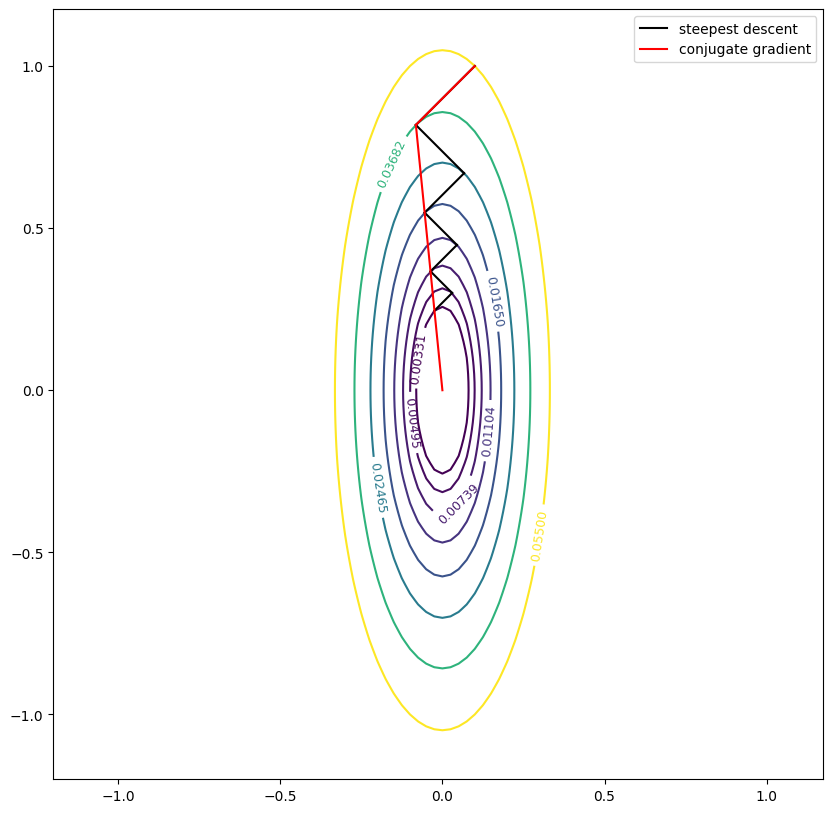

In [38]:

# funcion a minimizar
phi = lambda x: 0.5*x.dot(A.dot(x)) - x.dot(b)

# Make data.
x = np.arange(-1.2, 1.2, 0.025)
y = np.arange(-1.2, 1.2, 0.025)
X, Y = np.meshgrid(x, y)

Z = 0.5*(a11*X**2 + a22*Y**2)
fig, ax = plt.subplots(1,1, figsize=(10,10))

# puntos de Steepest descent
print(Xlist[0].dot(b))
X0 = Xlist[0]; x0 = X0[0]; y0 = X0[1]; f0 = phi(Xlist[0])
X1 = Xlist[1]; x1 = X1[0]; y1 = X1[1]; f1 = phi(Xlist[1])
X2 = Xlist[2]; x2 = X2[0]; y2 = X2[1]; f2 = phi(Xlist[2])
X3 = Xlist[3]; x3 = X3[0]; y3 = X3[1]; f3 = phi(Xlist[3])
X4 = Xlist[4]; x4 = X4[0]; y4 = X4[1]; f4 = phi(Xlist[4])
X5 = Xlist[5]; x5 = X5[0]; y5 = X5[1]; f5 = phi(Xlist[5])
X6 = Xlist[6]; x6 = X6[0]; y6 = X6[1]; f6 = phi(Xlist[6])
X7 = Xlist[7]; x7 = X7[0]; y7 = X7[1]; f7 = phi(Xlist[7])
CS = ax.contour(X,Y, Z, levels=[f7,f6,f5,f4,f3,f2,f1,f0])#,colors=['C05', 'C04', 'C03','C02', 'C01', 'C00'])
ax.clabel(CS, fontsize=9, inline=True)
ax.plot([x0,x1],[y0,y1],'k')
ax.plot([x1,x2],[y1,y2],'k')
ax.plot([x2,x3],[y2,y3],'k')
ax.plot([x3,x4],[y3,y4],'k')
ax.plot([x4,x5],[y4,y5],'k')
ax.plot([x5,x6],[y5,y6],'k')
ax.plot([x6,x7],[y6,y7],'k', label='steepest descent')
# puntos de CG
C0 = xcg[0]
C1 = xcg[1]
C2 = xcg[2]
ax.plot([C0[0],C1[0]],[C0[1],C1[1]],'r', label='conjugate gradient')
ax.plot([C1[0],C2[0]],[C1[1],C2[1]],'r')

ax.set_aspect('equal')
ax.legend()
plt.show()

## Test convergencia rapida

Sean $I\in \mathbb R^{n\times n}$ la matriz identidad, $D\in \mathbb R^{r\times r}$ una matriz simetrica y $U\in \mathbb R^{n\times r}$ con r<n, tales que
\begin{equation}
A = I + U DU^\top
\end{equation}
es simetrica definida positiva

In [41]:
N = 15
r = 3
Ran = np.random.rand(r,r)
D = Ran.T + Ran
U = np.random.rand(N,r)
A = np.eye(N) + U@D@U.T
xexact = np.ones(N)
b = A.dot(xexact) 
x, niter = ConjugateGradient_1(A, b, x0 = np.zeros(N))
print("residual \|Ax-b\|:",np.linalg.norm(A.dot(x[-1])-b))
print("n iter: ", niter)
#eigenval,_  = np.linalg.eig(A)
#print(eigenval)

[[27.23079749]]
 *** CG iteration 1, residual = 5.15e-01
[[27.23079749  0.51519464]
 [ 0.51519464  1.22769347]]
 *** CG iteration 2, residual = 4.66e-01
[[27.23079749  0.51519464  0.        ]
 [ 0.51519464  1.22769347  0.46617523]
 [ 0.          0.46617523  2.00563179]]
 *** CG iteration 3, residual = 2.11e-02
[[2.72307975e+01 5.15194638e-01 0.00000000e+00 0.00000000e+00]
 [5.15194638e-01 1.22769347e+00 4.66175229e-01 0.00000000e+00]
 [0.00000000e+00 4.66175229e-01 2.00563179e+00 2.11081413e-02]
 [0.00000000e+00 0.00000000e+00 2.11081413e-02 1.06547371e+00]]
 *** CG iteration 4, residual = 8.29e-09
residual \|Ax-b\|: 6.156252871316792e-11
n iter:  4


## Metodo de Gradientes Conjugados
### version 2 , version Lanczos

In [11]:
def ConjugateGradient_2(A, b,x0=None, TOL=1e-8, MAXITER = 100, print_iter=True):
    '''
    Algorithm 11.3.2: Conjugate Gradietns: Lanczos Version
    Input  : A s.d.p, b, x0
    Output : x sol. Ax = b
    '''
    if x0 is None: x0 = np.zeros(b.size)
    n, n = A.shape 
    Qlist = []
    k = 0
    xk = x0.copy()
    rk = b - A.dot(x0)
    beta0 = np.linalg.norm(rk.copy())
    alpha = []; alpha.append(0); beta = []; beta.append(beta0)
    q0 = np.zeros(n)
    d = []; d.append(0); el = []; nu = []; nu.append(0)
    c0 = np.zeros(n); clist = []; clist.append(c0)
    while beta[k] > TOL and k < MAXITER:
        q1 = rk/beta[k]; Qlist.append(q1)
        k += 1
        alphak = q1.dot(A.dot(q1)); alpha.append(alphak)
        if k == 1:
            d1 = alphak; d.append(d1)
            nu1 = beta0/d1; nu.append(nu1)
            ck = q1; clist.append(ck)
        else:
            el0 = beta[k-1]/d[k-1]; el.append(el0) 
            dk = alpha[k]-beta[k-1]*el0; d.append(dk)
            nuk = -beta[k-1]*nu[k-1]/d[k]; nu.append(nuk)
            ck = q1 - el0*clist[k-1]; clist.append(ck)
        xk += nu[k]*clist[k]
        rk = A.dot(q1) - alpha[k]*q1 - beta[k-1]*q0
        betak = np.linalg.norm(rk); beta.append(betak)
        q0 = q1.copy()
        if print_iter: printCG(k, betak)
    return xk, n

## Metodo de Gradientes Conjugados
### version 3 , version Hestenes-Stiefel

In [12]:
def ConjugateGradient_3(A, b, x0 = None, TOL=1e-8, MAXIT = 100, print_iter=True):
    '''
    Algorithm 11.3.3. Conjugate Gradients: Hestenes-Stiefel Version
    Input  : A s.d.p, b, x0
    Output : x sol. Ax = b
    '''
    if x0 is None: x0 = np.zeros(b.size)
    k = 0
    r0 = b - A.dot(x0) 
    # vectors
    x = []; r = []
    x.append(x0); r.append(r0)
    while np.linalg.norm(r[k]) > TOL and k < MAXIT:
        k += 1
        if k == 1:
            pk = r0.copy()
        else:
            taukm1 = r[k-1].dot(r[k-1])/(r[k-2].dot(r[k-2]))
            pk = r[k-1]  + taukm1 * pk
        muk = r[k-1].dot(r[k-1])/(pk.dot(A.dot(pk)))
        xk = x[k-1] + muk * pk; x.append(xk)
        rk = r[k-1] - muk*A.dot(pk); r.append(rk)
        if print_iter: printCG(k, np.linalg.norm(rk))
    return x[k], k

In [13]:
def practicalCG(A, b, x0=None, TOL=1e-8, MAXIT=100, print_iter=True):
    '''
    Algorithm Practical Conjugate Gradients.  Section 11.3.8
    Input  : A s.d.p, b, x0
    Output : x sol. Ax = b
    '''
    if x0 is None: x0 = np.zeros(b.size)
    k = 0
    x = x0.copy()
    r = b - A.dot(x)
    rhoc = r.dot(r)
    delta = TOL*np.linalg.norm(b)
    while np.sqrt(rhoc) > delta:
        k += 1 
        if k == 1: 
            p = r.copy()
        else: 
            tau = rhoc/rhom
            p = r + tau*p
        w = A.dot(p)
        mu = rhoc/(p.dot(w))
        x += mu*p
        r -= mu*w
        rhom = rhoc.copy()
        rhoc = r.dot(r)
        if print_iter: printCG(k, np.sqrt(rhoc))
    return x, k

## Ejemplo 1:
\begin{equation*} A = \left(\begin{array}{cc} 2&-1\\-1&2\end{array}\right), \quad b = \left( \begin{array}{c} 1\\0 \end{array}\right) \end{equation*}

In [42]:
# Example 1
A = np.array([[2.0,-1.0],[-1.0,2.0]], dtype=np.float64) 
b = np.array([1.0,0.0], dtype=np.float64)

print(" Conjugate Gradients version 1 \n")
x1,n1 = ConjugateGradient_1(A,b)
print(" Conjugate Gradients version 2 \n")
x2,n2 = ConjugateGradient_2(A,b)
print(" Conjugate Gradients version 3 \n")
x3,n3 = ConjugateGradient_3(A,b)
print(" Practical Conjugate Gradients\n")
x4,n4 = practicalCG(A,b)
x4

 Conjugate Gradients version 1 

[[2.]]
 *** CG iteration 1, residual = 1.00e+00
[[2. 1.]
 [1. 2.]]
 *** CG iteration 2, residual = 0.00e+00
 Conjugate Gradients version 2 

 *** CG iteration 1, residual = 1.00e+00
 *** CG iteration 2, residual = 0.00e+00
 Conjugate Gradients version 3 

 *** CG iteration 1, residual = 5.00e-01
 *** CG iteration 2, residual = 0.00e+00
 Practical Conjugate Gradients

 *** CG iteration 1, residual = 5.00e-01
 *** CG iteration 2, residual = 0.00e+00


array([0.66666667, 0.33333333])

Ejemplo 2:
\begin{equation*} A = \left(\begin{array}{ccc} 5&1&1\\1&5&-1 \\ 1&-1&5\end{array}\right), \quad b = \left( \begin{array}{c} 4\\2\\-4 \end{array}\right) \end{equation*}

In [43]:
# Example 2
A = np.array([[5,1,1],[1,5,-1],[1,-1,5]], dtype=np.float64) 
b = np.array([4,2,-4], dtype=np.float64)

print(" Conjugate Gradients version 1 \n")
x1,n1 = ConjugateGradient_1(A,b)
print(" Conjugate Gradients version 2 \n")
x2,n2 = ConjugateGradient_2(A,b)
print(" Conjugate Gradients version 3 \n")
x3,n3 = ConjugateGradient_3(A,b)
print(" Practical Conjugate Gradients\n")
x4,n4 = practicalCG(A,b)


 Conjugate Gradients version 1 

[[5.]]
 *** CG iteration 1, residual = 1.41e+00
[[5.         1.41421356]
 [1.41421356 4.        ]]
 *** CG iteration 2, residual = 8.31e-16
 Conjugate Gradients version 2 

 *** CG iteration 1, residual = 1.41e+00
 *** CG iteration 2, residual = 8.31e-16
 Conjugate Gradients version 3 

 *** CG iteration 1, residual = 1.70e+00
 *** CG iteration 2, residual = 6.96e-16
 Practical Conjugate Gradients

 *** CG iteration 1, residual = 1.70e+00
 *** CG iteration 2, residual = 6.96e-16


## Test Gradientes Conjugados

$$
A = I_{m} \otimes C_1 + C_2 \otimes I_{m},\quad
C_{1}
=
\begin{bmatrix}
c      &     a  &      0 & \ldots & 0     \\
a      &     c  &      a & \ddots & \vdots\\
0      & \ddots & \ddots & \ddots & 0     \\
\vdots & \ddots & a      & c      & a     \\
0      & \ldots & 0      & a      & c
\end{bmatrix}, \quad
C_{2}
=
\begin{bmatrix}
c      &     b  &      0 & \ldots & 0     \\
b      &     c  &      b & \ddots & \vdots\\
0      & \ddots & \ddots & \ddots & 0     \\
\vdots & \ddots & b      & c      & b     \\
0      & \ldots & 0      & b      & c
\end{bmatrix}
$$

1. Test con numero de condicion acotado (<9): $a= 1/9,\,b = 1/9,\, c = 5/18$.

2. Test con numero de condicion no acotado : $a= -1,\,b = -1,\, c = 2$.


In [44]:
import pandas as pd
import scipy.sparse as sp

In [45]:
def testproblem(num, m):
    if num == 1:
    # Poisson matrix
        a = -1;
        b = a;
        c = 2;
    elif num == 2:
    # Averaging problem
        a = 1.0/9.0;
        b = a;
        c = 5.0/18.0;
    # end 
    C1 = c*np.diag(np.ones(m),0)+a*np.diag(np.ones(m-1),-1)+a*np.diag(np.ones(m-1),1);
    C2 = c*np.diag(np.ones(m),0)+b*np.diag(np.ones(m-1),-1)+b*np.diag(np.ones(m-1),1)
    A = np.kron(np.eye(m),C1) + np.kron(C2, np.eye(m))
    bvector = np.random.rand(m*m)
    return sp.csr_matrix(A), bvector

In [46]:
A, b = testproblem(num = 1, m=2)
print(A)

  (0, 0)	4.0
  (0, 1)	-1.0
  (0, 2)	-1.0
  (1, 0)	-1.0
  (1, 1)	4.0
  (1, 3)	-1.0
  (2, 0)	-1.0
  (2, 2)	4.0
  (2, 3)	-1.0
  (3, 1)	-1.0
  (3, 2)	-1.0
  (3, 3)	4.0


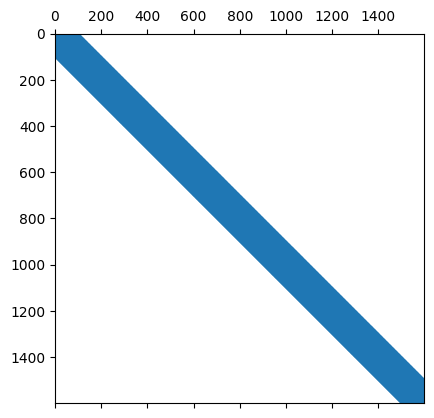

In [47]:
A,_=testproblem(num=2, m=40)
plt.spy(A)

In [48]:
def ConjugateGradient(A, b, x0 = None, TOL=1e-8, MAXIT = 100, print_iter=True):
    '''
    Algorithm 11.3.3. Conjugate Gradients: Hestenes-Stiefel Version
    Input  : A s.d.p, b, x0
    Output : x sol. Ax = b
    '''
    if x0 is None: x0 = np.zeros(b.size)
    k = 0
    r0 = b - A.dot(x0) 
    # vectors
    x = []; r = []
    x.append(x0); r.append(r0); pk=r0.copy()
    for k in range(MAXIT):
        alphak =  r[k].dot(r[k])/(pk.dot(A.dot(pk)))
        xnew = x[k] + alphak * pk; x.append(xnew)
        rnew = r[k] - alphak*A.dot(pk); r.append(rnew)
        betak = rnew.dot(rnew)/(r[k].dot(r[k]))
        pk = rnew + betak*pk
        if print_iter: printCG(k, np.linalg.norm(rnew))
        if np.linalg.norm(rnew)<TOL:
            break
    return x, k
def printCG(iter, res):
    print(f" *** CG iteration {iter}, residual = {res:1.2e}")   
def TestCG_example(examplenumber, mm=5):
    kappa = np.zeros(mm)
    nn =np.zeros(mm, dtype=np.int64)
    M = [5*2**i for i in range(mm)]
    for m in range(len(M)):
        A, b = testproblem(examplenumber, M[m])
        x, nn[m] = ConjugateGradient(A,b, MAXIT=1000, print_iter=False)
        kappa[m] = np.linalg.cond(A.todense())
    tab = pd.DataFrame({'m':M, 'Matrix dim':np.square(M), 'Condition number':kappa, 'number of CG iterations': nn})
    return tab

In [49]:
tab1 = TestCG_example(examplenumber=1, mm=5)
tab1 = tab1.style.set_caption('Example, bounded condition number')
tab1

,m,Matrix dim,Condition number,number of CG iterations
0,5,25,13.928203,12
1,10,100,48.374150,33
2,20,400,178.064275,67
3,40,1600,680.617070,135
4,80,6400,2658.406502,271


In [50]:
tab2 = TestCG_example(examplenumber=2, mm=5)
tab2 = tab2.style.set_caption('Example, increasing condition number')
tab2

,m,Matrix dim,Condition number,number of CG iterations
0,5,25,5.510847,12
1,10,100,7.605644,23
2,20,400,8.572340,27
3,40,1600,8.883994,29
4,80,6400,8.970008,31


### Using scipy.sparse.linlg.cg

In [ ]:
class cg_counter(object):
    def __init__(self, A, b, disp=True):
        self._disp = disp
        self.niter = 0
        self.A = A
        self.b = b
        self.rk = []
    def __call__(self, xk=None):
        self.niter += 1
        if self._disp:
            rk = self.b-self.A.dot(xk) 
            rhok = np.linalg.norm(rk)
            # print('iter %3i\trk = %s' % (self.niter, str(rhok)))      
            self.rk.append(rk)


In [ ]:
A, b = testproblem(1, 80)
counter = cg_counter(A, b)
x, info = cg(A, b, tol=10**(-8), maxiter=200, callback=counter)
counter.niter

In [ ]:
def Test_scipyCG_example(examplenumber, mm=5):
    kappa = np.zeros(mm)
    nn =np.zeros(mm, dtype=np.int64)
    M = [5*2**i for i in range(mm)]
    for m in range(len(M)):
        A, b = testproblem(examplenumber, M[m])
        counter = cg_counter(A, b)
        x, info = cg(A,b, tol=10**(-8), maxiter=200, callback=counter)
        nn[m] = counter.niter
        kappa[m] = np.linalg.cond(A.todense())
    tab = pd.DataFrame({'m':M, 'Matrix dim':np.square(M), 'Condition number':kappa, 'number of CG iterations': nn})
    return tab

In [ ]:
tab1 = Test_scipyCG_example(examplenumber=1, mm=5)
tab1 = tab1.style.set_caption('Example, bounded condition number')
tab1

In [260]:
tab2 = Test_scipyCG_example(examplenumber=2, mm=5)
tab2 = tab2.style.set_caption('Example, increasing condition number')
tab2

,m,Matrix dim,Condition number,number of CG iterations
0,5,25,13.928203,13
1,10,100,48.374150,32
2,20,400,178.064275,62
3,40,1600,680.617070,123
4,80,6400,2658.406502,242


## Example 6.15 Demmel
El objetivo de este ejemplo es mostrar que CG puede converger mas rapido que el estimado que obtuvimos:
\begin{equation}
\frac{\|r_k\|_2}{\|r_0\|_2} \leq \frac{1}{T_{k}(1 + \frac{2}{\kappa-1})} 
\end{equation}

Consideramos 8 sistemas lineales de dimensi\'on $n=10^4$ y el mismo n\'umero de condici\'on $\kappa \approx 4134$, sin embargo su convergencia es radicalmente diferente.

El primer sistema lineal es el sistema asociado a la ecuacion de Poisson usando diferencias finitas

Tenemos 7 sistemas lineales diagonales de la forma $D_{i} x = b$, donde cada $D_i$ tiene mismo numero de condicion que la matriz $A$. Cada $D_i$ se construye tal que sus $m_i$ valores propios mas pequenos y sus $m_i$ valores propios mas grandes coinciden con los correspondientes valores propios de la matriz $A$. El resto de los $n-2m_i$ valores propios de $D_i$ se toman como el la media geometrica de los mayores y menores valores propios. Asi cada $D_i$ tiene solo $2m_i+1$ valores propios distintos.

Tambien graficamos la cota del error relativo
\begin{equation}
 \frac{1}{T_{k}(1 + \frac{2}{\kappa-1})} 
\end{equation}

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import cg, eigs
from scipy.stats.mstats import gmean
from scipy.special import eval_chebyt
import pandas as pd

Calculamos la matriz de diferencias finitas asociada a la ecuacion de Poisson

In [86]:
n = 100
# one dimensional finite difference matrix
A1d = np.diag(2*np.ones(n)) + np.diag(-1*np.ones(n-1),-1)+ np.diag(-1*np.ones(n-1),1)

# two dimensional finite difference matrix
A2d = np.kron(np.eye(n),A1d) + np.kron(A1d, np.eye(n))

A = csr_matrix(A2d)
# random vector as right hand side
# b = np.random.rand(n**2)
b = np.random.normal(0, 1, n**2)

Calculamos los valores propios de esta matriz. 

In [33]:
# Eigenvalues and condition number
lambdas = [2*(1.0-np.cos(np.pi*j/(n+1))) for j in range(1,n+1)]
kappa = lambdas[-1]/lambdas[0]

l2d = np.zeros(n**2)
k = 0
for i in range(0,n):
    for j in range(0, n):
        l2d[k] = lambdas[i]+lambdas[j]
        k = k+1
l2d = np.sort(l2d)
lamSM,_ = eigs(A,k=3,which='SM')
lamLM,_ = eigs(A,k=3,which='LM')
print(l2d)
print(lamSM, lamLM)


[1.93487083e-03 4.83624115e-03 4.83624115e-03 ... 7.99516376e+00
 7.99516376e+00 7.99806513e+00]
[0.00193487+0.j 0.00483624+0.j 0.00483624+0.j] [7.99806513+0.j 7.99516376+0.j 7.99516376+0.j]


In [52]:
class cg_counter(object):
    def __init__(self, A, b, disp=True):
        self._disp = disp
        self.niter = 0
        self.A = A
        self.b = b
        self.rk = []
    def __call__(self, xk=None):
        self.niter += 1
        if self._disp:
            rk = self.b-self.A.dot(xk) 
            rhok = np.linalg.norm(rk)
            # print('iter %3i\trk = %s' % (self.niter, str(rhok)))      
            self.rk.append(rk)


print( )

[1.93487083e-03 4.83624115e-03 4.83624115e-03 7.73761147e-03
 9.66873948e-03 7.99033126e+00 7.99226239e+00 7.99516376e+00
 7.99516376e+00 7.99806513e+00]


In [90]:
m1 = 1; dm1 = 1+2*m1
gm1 = gmean(np.concatenate((l2d[:m1],  l2d[-m1:])))
D1 = np.diag(np.hstack((l2d[:m1],gm1*np.ones(n**2-2*m1), l2d[-m1:]) ))
print("geometric mean for D_1 :", gm1)
D1sp = csr_matrix(D1)

m2 = 5; dm2 = 1+2*m2
gm2 = gmean(np.concatenate((l2d[:m2],  l2d[-m2:])))
D2 = np.diag(np.hstack((l2d[:m2],gm2*np.ones(n**2-2*m2), l2d[-m2:]) ))
print("geometric mean for D_2 :", gm2)
D2sp = csr_matrix(D2)

m3 = 20; dm3 = 1+2*m3
gm3 = gmean(np.concatenate((l2d[:m3],  l2d[-m3:])))
D3 = np.diag(np.hstack((l2d[:m3],gm3*np.ones(n**2-2*m3), l2d[-m3:]) ))
print("geometric mean for D_3 :", gm3)
D3sp = csr_matrix(D3)

m4 = 40; dm4 = 1+2*m4
gm4 = gmean(np.concatenate((l2d[:m4],  l2d[-m4:])))
D4 = np.diag(np.hstack((l2d[:m4],gm4*np.ones(n**2-2*m4), l2d[-m4:]) ))
print("geometric mean for D_4 :", gm4)
D4sp = csr_matrix(D4)

m5 = 100; dm5 = 1+2*m5
gm5 = gmean(np.concatenate((l2d[:m5],  l2d[-m5:])))
D5 = np.diag(np.hstack((l2d[:m5],gm5*np.ones(n**2-2*m5), l2d[-m5:]) ))
print("geometric mean for D_5 :", gm5)
D5sp = csr_matrix(D5)

m6 = 200; dm6 = 1+2*m6
gm6 = gmean(np.concatenate((l2d[:m6],  l2d[-m6:])))
D6 = np.diag(np.hstack((l2d[:m6],gm6*np.ones(n**2-2*m6), l2d[-m6:]) ))
print("geometric mean for D_6 :", gm6)
D6sp = csr_matrix(D6)

m7 = 2500; dm7 = 1+2*m7
gm7 = gmean(np.concatenate((l2d[:m7],  l2d[-m7:])))
D7 = np.diag(np.hstack((l2d[:m7],gm7*np.ones(n**2-2*m7), l2d[-m7:]) ))
print("geometric mean for D_7 :", gm7)
D7sp = csr_matrix(D7)

geometric mean for D_1 : 0.12439944907934594
geometric mean for D_2 : 0.20153565128422213
geometric mean for D_3 : 0.33403981346244566
geometric mean for D_4 : 0.4451384688483489
geometric mean for D_5 : 0.6637394245148277
geometric mean for D_6 : 0.9061185551904
geometric mean for D_7 : 2.651597855454122


In [87]:
counter_A = cg_counter(A, b)
x, info = cg(A, b, tol=10**(-13), maxiter=500, callback=counter_A)

counter_D1 = cg_counter(D1sp, b)
xD1, info = cg(D1sp, b, tol=10**(-13), maxiter=200, callback=counter_D1)

counter_D2 = cg_counter(D2sp, b)
xD2, info = cg(D2sp, b, tol=10**(-13), maxiter=200, callback=counter_D2)

counter_D3 = cg_counter(D3sp, b)
xD3, info = cg(D3sp, b, tol=10**(-13), maxiter=200, callback=counter_D3)

counter_D4 = cg_counter(D4sp, b)
xD4, info = cg(D4sp, b, tol=10**(-13), maxiter=200, callback=counter_D4)

counter_D5 = cg_counter(D5sp, b)
xD5, info = cg(D5sp, b, tol=10**(-13), maxiter=200, callback=counter_D5)

counter_D6 = cg_counter(D6sp, b)
xD6, info = cg(D6sp, b, tol=10**(-13), maxiter=200, callback=counter_D6)

counter_D7 = cg_counter(D7sp, b)
xD7, info = cg(D7sp, b, tol=10**(-13), maxiter=500, callback=counter_D7)

In [88]:
i
df = pd.DataFrame({'Matriz': ['A','D1','D2','D3','D4','D5','D6','D7'], 
                   'Num. val.p. distintos':[n**2, dm1,dm2,dm3,dm4,dm5,dm6,dm7],
                   'num. CG. iteraciones': [len(counter_A.rk), len(counter_D1.rk),len(counter_D2.rk),len(counter_D3.rk),len(counter_D4.rk),len(counter_D5.rk),len(counter_D6.rk),len(counter_D7.rk)]})
df


,Matriz,Num. val.p. distintos,num. CG. iteraciones
0,A,10000,405
1,D1,3,4
2,D2,11,11
3,D3,41,26
4,D4,81,50
5,D5,201,98
6,D6,401,142
7,D7,5001,378


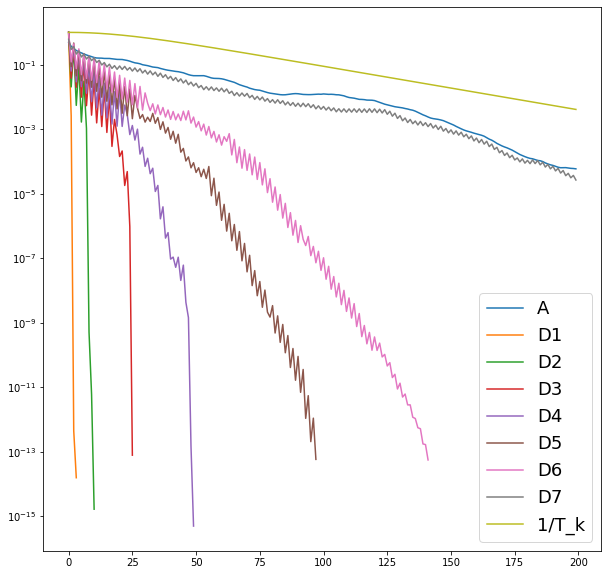

In [89]:
def rkoverr0(rk):
    return [(np.linalg.norm(rk[i]))/(np.linalg.norm(b)) for i in range(len(rk)) ]
fig, ax = plt.subplots(1,1, figsize=(10,10))

ax.semilogy(range(min(len(counter_A.rk),200))  , rkoverr0(counter_A.rk)[:200]  , label='A')
ax.semilogy(range(len(counter_D1.rk)) , rkoverr0(counter_D1.rk) , label='D1')
ax.semilogy(range(len(counter_D2.rk)) , rkoverr0(counter_D2.rk) , label='D2')
ax.semilogy(range(len(counter_D3.rk)) , rkoverr0(counter_D3.rk) , label='D3')
ax.semilogy(range(len(counter_D4.rk)) , rkoverr0(counter_D4.rk) , label='D4')
ax.semilogy(range(len(counter_D5.rk)) , rkoverr0(counter_D5.rk) , label='D5')
ax.semilogy(range(len(counter_D6.rk)) , rkoverr0(counter_D6.rk) , label='D6')
ax.semilogy(range(min(len(counter_D7.rk),200)) , rkoverr0(counter_D7.rk)[:200] , label='D7')

ax.semilogy(range(200), [1.0/eval_chebyt(n, 1+2.0/(kappa-1)) for n in range(200)], label='1/T_k' )
ax.legend(loc=4,prop={'size': 18})
plt.show()


### Observaciones 
- Si los valores propios mas pequenos y mas grandes de la matriz $A$ son pocos en numero (o estan clusterizados) entonces CG convergera mucho mas rapido que el estimado del analisis, el cual solo se basa en el numero de condicion de la matriz $A$.
- El comportamiento de CG en aritmetica de punto flotante puede ser significativamente distinto que su comportamiento en aritmetica exacta. Vemos esto ya que observamos que el numero de iteraciones requeridas para converger difiere del numero de valores propios distintos cuando sabemos que estos deberian ser identicos.